# Image Classification using ```albumentations``` and PyTorch

[Reference](https://albumentations.ai/docs/autoalbument/examples/cifar10/)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/arjun/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/arjun/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/arjun/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Define hyper-parameters-
num_epochs = 50
batch_size = 256
learning_rate = 1e-4

#### Normalization values for images.

For each image, the search pipeline will subtract `mean` and divide by `std`. Normalization is applied after transforms defined in `preprocessing`. Note that regardless of `input_dtype`, the normalization function will always receive a `float32` input with values in the range [0.0, 1.0], so you should define `mean` and `std` values accordingly.

In [3]:
# Define transformations using albumentations-
transform = A.Compose(
    [
        # A.Resize(width = 32, height = 32),
        # A.RandomCrop(width = 20, height = 20),
        A.Rotate(limit = 40, p = 0.9, border_mode = cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.1),
        A.RGBShift(r_shift_limit = 25, g_shift_limit = 25, b_shift_limit = 25, p = 0.9),
        A.OneOf([
            A.Blur(blur_limit = 3, p = 0.5),
            A.ColorJitter(p = 0.5),
        ], p = 1.0),
        A.Normalize(
            # mean = [0.4914, 0.4822, 0.4465],
            # std = [0.247, 0.243, 0.261],
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255,
        ),
        # This is not dividing by 255, which it does in PyTorch-
        ToTensorV2(),
    ]
)

In [4]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(
        self, root = "~/data/cifar10",
        train = True, download = True,
        transform = None
    ):
        super().__init__(
            root = root, train = train,
            download = download, transform = transform
        )

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed["image"]

        return image, label
    

In [5]:
# Define train and validate sets-
train_dataset = Cifar10Dataset(
    root = '/home/arjun/Downloads/.data/', train = True,
    download = True, transform = transform
)

val_dataset = Cifar10Dataset(
    root = '/home/arjun/Downloads/.data/', train = False,
    download = True, transform = None
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Define train and validate loaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
    )

val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset, batch_size = batch_size,
    shuffle = True
    )

In [7]:
print(f"len(train_dataset) = {len(train_dataset)} & len(val_dataset) = {len(val_dataset)}")

len(train_dataset) = 50000 & len(val_dataset) = 10000


In [8]:
print(f"len(train_loader) = {len(train_loader)} & len(val_loader) = {len(val_loader)}")

len(train_loader) = 196 & len(val_loader) = 40


In [9]:
# Sanity check-
len(train_dataset) / batch_size, len(val_dataset) / batch_size

(195.3125, 39.0625)

In [10]:
# Sanity check-
images, labels = next(iter(train_loader))

images.size(), labels.shape

(torch.Size([256, 3, 32, 32]), torch.Size([256]))

In [11]:
images.min(), images.max()

(tensor(0.), tensor(1.))

In [12]:
# Unnormalize images-
# images = images / 2 + 0.5

# Transpose axes for visualization-
images = np.transpose(images.numpy(), (0, 2, 3, 1))

images.shape

(256, 32, 32, 3)

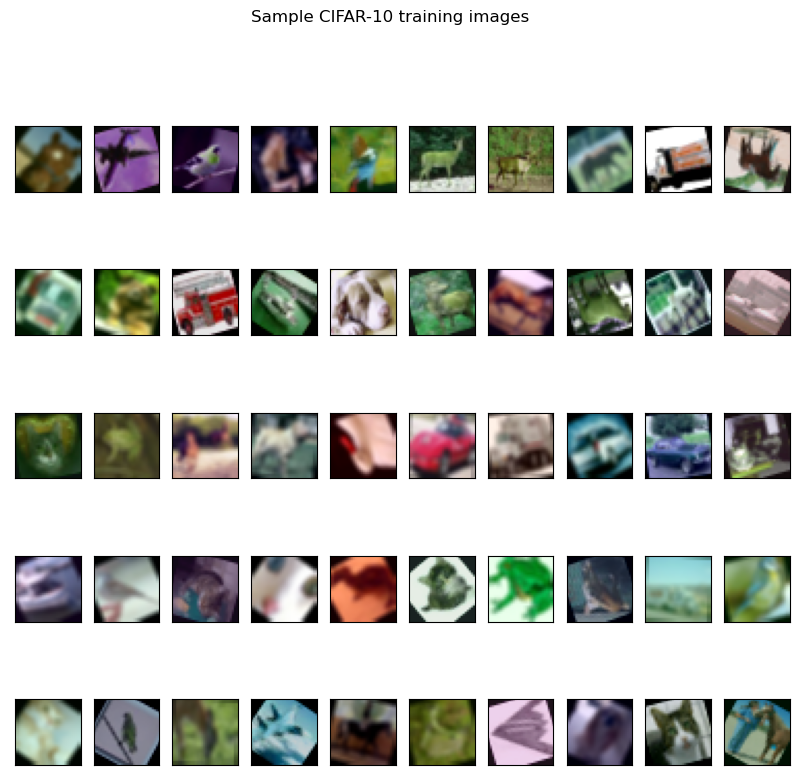

In [13]:
# Visualize 50 images from training set-
plt.figure(figsize = (10, 9))

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(images[i])
    # get current axes-
    ax = plt.gca()

    # hide x-axis-
    ax.get_xaxis().set_visible(False)

    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Sample CIFAR-10 training images")
plt.show()

In [14]:
del images, labels